In [ ]:
import pandas as pd
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import torch  
import torch.nn as nn  
import torch.optim as optim  
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset


data = pd.read_csv('FGDD.csv')
data = data[~data['Disease_id'].isnull()]
data = data.reset_index(drop=True)


# ------------------ pre-processing ------------------

In [2]:
data['Variant_Gene_id_1'].fillna(0, inplace=True)
data['Variant_Gene_id_2'].fillna(0, inplace=True)

data['Variant_Gene_id_1'] = data['Variant_Gene_id_1'].astype(int)
data['Variant_Gene_id_1'] = data['Variant_Gene_id_1'].astype(str)
data['Variant_Gene_id_2'] = data['Variant_Gene_id_2'].astype(int)
data['Variant_Gene_id_2'] = data['Variant_Gene_id_2'].astype(str)
data['Disease_id'] = data['Disease_id'].astype(int)
data['Disease_id'] = data['Disease_id'].astype(str)
# 填充缺失 age
data['age'].fillna(data['age'].mean(), inplace=True)

# 填充缺失 race
data['race'].fillna('unknown', inplace=True)

# 填充缺失 region
data['region'].fillna('unknown', inplace=True)

# 填充缺失 gender
data['gender'].fillna('unknown', inplace=True)

In [3]:
# 选择特征列
patient_information = ['gender', 'age', 'region', 'race']
variant_information = ['Variant_Gene_id_1', 'Variant_Gene_id_2', 'Variant_Gene_chromosome_name_1', 'Variant_Gene_chromosome_name_2', 'Variant_Gene_chromosome_location_1', 'Variant_Gene_chromosome_location_2', 
'Variant_Gene_exon_count_1', 'Variant_Gene_exon_count_2']
phenotype_information = [col for col in data.columns if col.startswith('HP')]

features = []
features = features + patient_information 
features = features + variant_information
features = features + phenotype_information

In [4]:
X = pd.get_dummies(data[features], prefix=None, prefix_sep='_')
y = data['Disease_id']

le = LabelEncoder()
y = le.fit_transform(y)
label_mappings = dict(zip(le.transform(le.classes_), le.classes_))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# ------------------ Global explaination ------------------

In [5]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

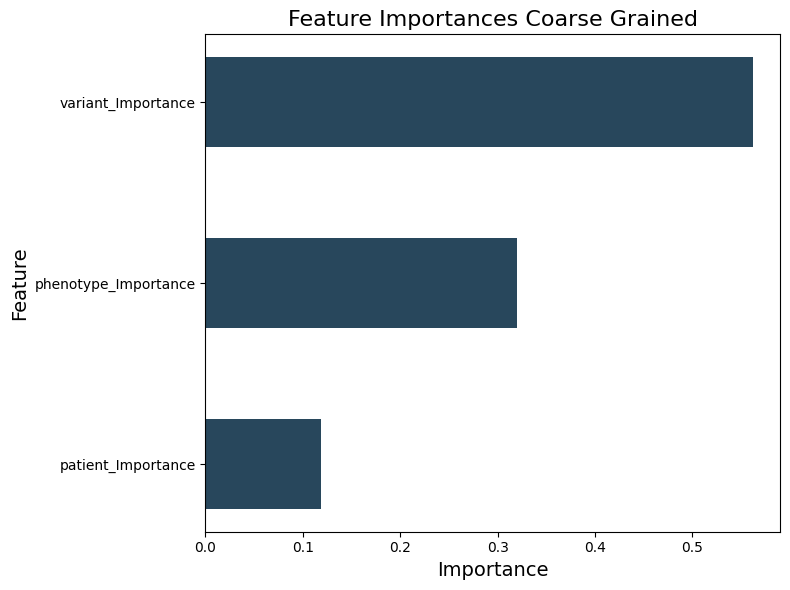

In [6]:
feature_importances = rf.feature_importances_

importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
importances = importances.sort_values('importance', ascending=False)

# 合并 hp features
phenotype_features = importances[importances['feature'].str.startswith('HP:')]
phenotype_importance = phenotype_features['importance'].sum()
phenotype_row = pd.DataFrame({  
    'feature': ['phenotype_Importance'],  
    'importance': [phenotype_importance]  
})

# 合并 variant features
variant_features = importances[importances['feature'].str.startswith('Variant')]
variant_importance = variant_features['importance'].sum()
variant_row = pd.DataFrame({  
    'feature': ['variant_Importance'],  
    'importance': [variant_importance]  
})


#importances_filtered = importances[~importances['feature'].str.startswith('HP:')]
#importances_filtered = importances_filtered[~importances['feature'].str.startswith('Variant')]


# 合并 patient features
region_features = importances[importances['feature'].str.startswith('region')]
race_features   = importances[importances['feature'].str.startswith('race')]
gender_features = importances[importances['feature'].str.startswith('gender')]
age_features    = importances[importances['feature'].str.startswith('age')]    

region_importance = region_features['importance'].sum()
race_importance = race_features['importance'].sum()
gender_importance = gender_features['importance'].sum()
age_importance = age_features['importance'].sum()

patient_features = pd.DataFrame({'feature':[], 'importance':[]})
patient_features = patient_features.append(region_features, ignore_index=True)
patient_features = patient_features.append(race_features, ignore_index=True)
patient_features = patient_features.append(gender_features, ignore_index=True)
patient_features = patient_features.append(age_features, ignore_index=True)


patient_importance = region_importance + race_importance + gender_importance + age_importance
# 合并 patient fetures
patient_row = pd.DataFrame({  
    'feature': ['patient_Importance'],  
    'importance': [patient_importance]  
})

importances_coarse_grained = pd.DataFrame({'feature':[], 'importance':[]})
importances_coarse_grained = importances_coarse_grained.append(phenotype_row, ignore_index=True) 
importances_coarse_grained = importances_coarse_grained.append(variant_row, ignore_index=True) 
importances_coarse_grained = importances_coarse_grained.append(patient_row, ignore_index=True) 
importances_coarse_grained = importances_coarse_grained.sort_values('importance', ascending=True)


fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(importances_coarse_grained['feature'], importances_coarse_grained['importance'] ,height=0.5, color = '#28475C')
ax.set_title('Feature Importances Coarse Grained', fontsize=16)
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
fig.tight_layout()

plt.savefig('coarse_grained.jpg',dpi=400)
#plt.xticks(rotation=90)
plt.show()


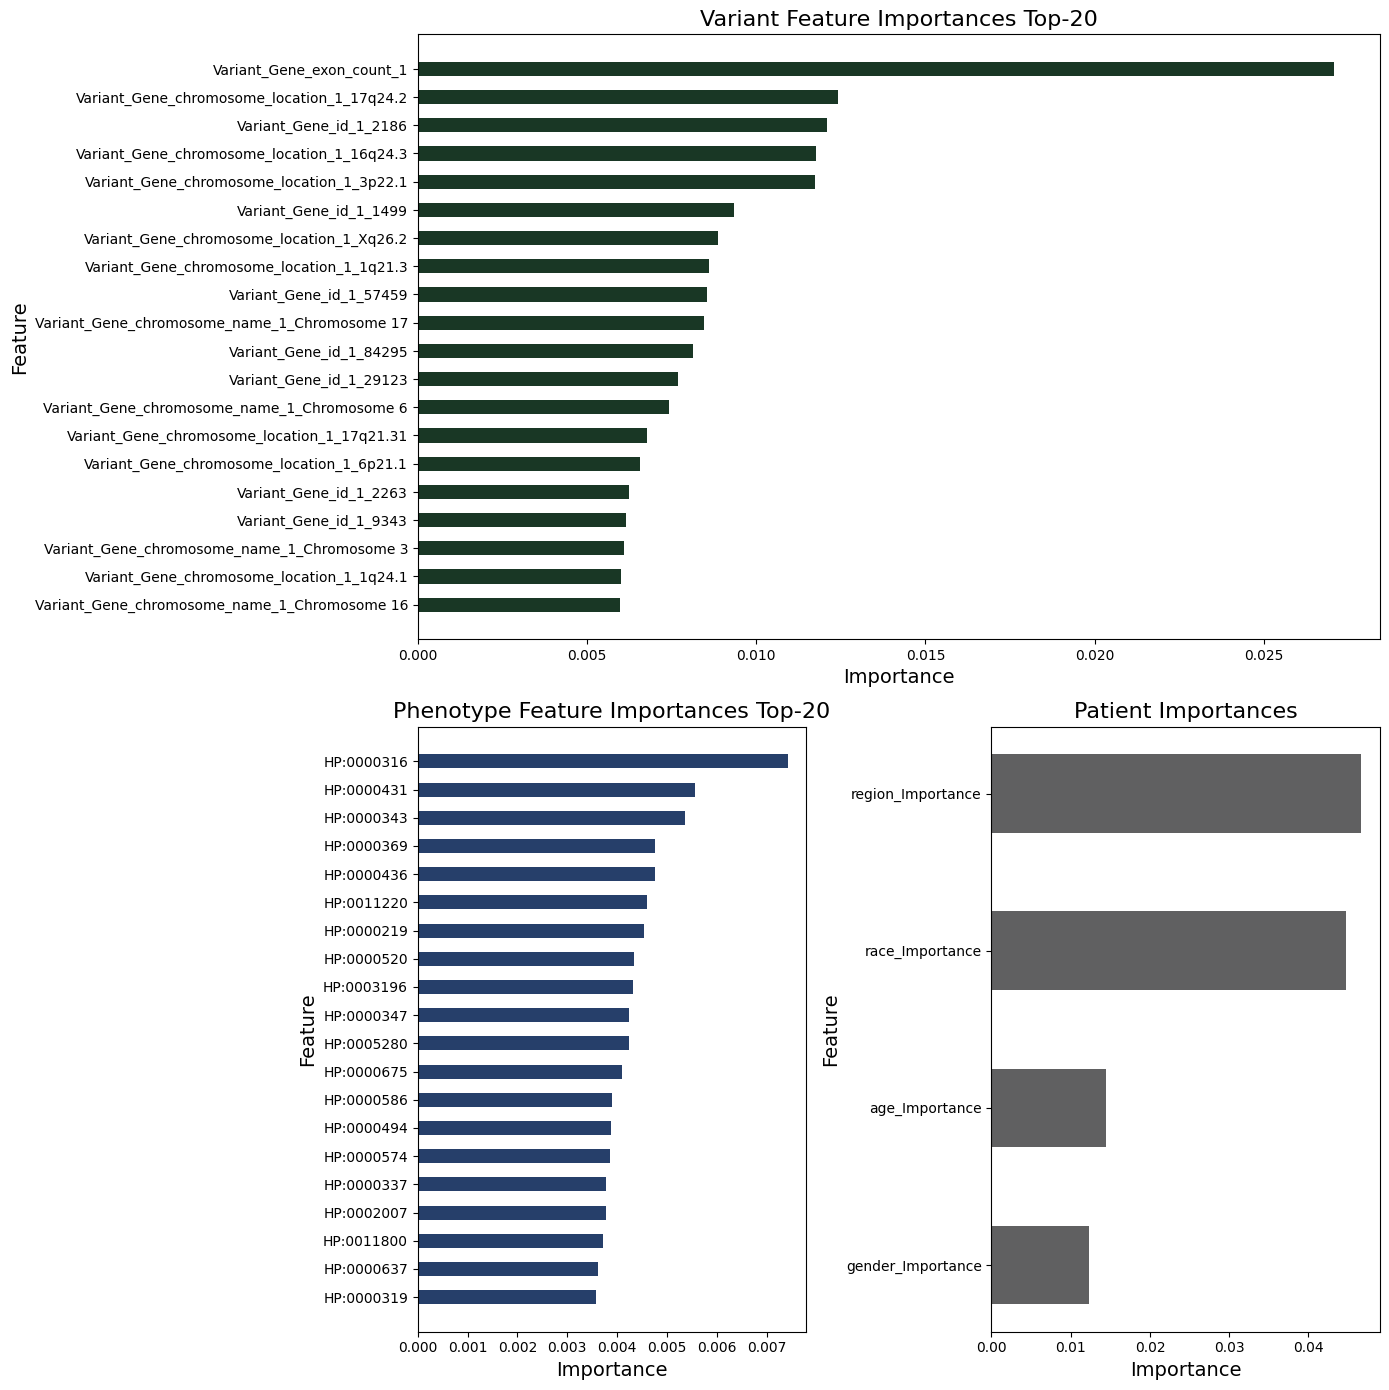

In [7]:
import matplotlib.pyplot as plt  
from matplotlib import gridspec  
  
fig = plt.figure(figsize=(14, 14))  
grid = gridspec.GridSpec(2, 2, figure=fig)  



# ================== variant feature ==================
ax1 = fig.add_subplot(grid[0, :])  # 这里的':'表示跨越所有列，即colspan=2的效果  
ax1.barh(variant_features.head(20)['feature'], variant_features.head(20)['importance'], height=0.5, color='#193725')  
ax1.set_title('Variant Feature Importances Top-20', fontsize=16)  
ax1.set_xlabel('Importance', fontsize=14)  
ax1.set_ylabel('Feature', fontsize=14)  
ax1.invert_yaxis() 





# ================== patient ==================
ax2 = fig.add_subplot(grid[1, 1])  
region_row = pd.DataFrame({  
    'feature': ['region_Importance'],  
    'importance': [region_importance]  
})
race_row = pd.DataFrame({  
    'feature': ['race_Importance'],  
    'importance': [race_importance]  
})
gender_row = pd.DataFrame({  
    'feature': ['gender_Importance'],  
    'importance': [gender_importance]  
})
age_row = pd.DataFrame({  
    'feature': ['age_Importance'],  
    'importance': [age_importance]  
})
patient_features_fine_grained = pd.DataFrame({'feature':[], 'importance':[]})
patient_features_fine_grained = patient_features_fine_grained.append(region_row, ignore_index=True)
patient_features_fine_grained = patient_features_fine_grained.append(race_row, ignore_index=True)
#patient_features_fine_grained = patient_features_fine_grained.append(source_row, ignore_index=True)
patient_features_fine_grained = patient_features_fine_grained.append(gender_row, ignore_index=True)
patient_features_fine_grained = patient_features_fine_grained.append(age_row, ignore_index=True)
patient_features_fine_grained = patient_features_fine_grained.sort_values(by='importance', ascending=True)  

ax2.barh(patient_features_fine_grained['feature'], patient_features_fine_grained['importance'] ,height=0.5 , color='#606061')
ax2.set_title('Patient Importances', fontsize=16)
ax2.set_xlabel('Importance', fontsize=14)
ax2.set_ylabel('Feature', fontsize=14)



# ================== phenotype feature ==================
ax3 = fig.add_subplot(grid[1, 0])  
ax3.barh(phenotype_features.head(20)['feature'], phenotype_features.head(20)['importance'], height=0.5 , color='#263F6A')  
ax3.set_title('Phenotype Feature Importances Top-20', fontsize=16)  
ax3.set_xlabel('Importance', fontsize=14)  
ax3.set_ylabel('Feature', fontsize=14)  
ax3.invert_yaxis()  # 如果需要，反转y轴顺序以匹配条形图的显示顺序  



  
# 调整子图间距（如果需要）  
#plt.subplots_adjust(wspace=0.4, hspace=0.3)  # wspace是宽度间距，hspace是高度间距  
plt.tight_layout()
plt.savefig('fine_grained.jpg',dpi=400)
   
plt.show()

# ------------------ Local explaination ------------------

In [8]:
from catboost import CatBoostClassifier
import shap


cat = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=12)
cat.fit(X, y, verbose=100)
y_pred = cat.predict(X_test)
print('catboost Test Accuracy:', accuracy_score(y_test, y_pred))

0:	learn: 5.2381945	total: 367ms	remaining: 1m 49s
100:	learn: 2.3953703	total: 20.6s	remaining: 40.5s
200:	learn: 2.0171114	total: 40.2s	remaining: 19.8s
299:	learn: 1.7740404	total: 59.5s	remaining: 0us
catboost Test Accuracy: 0.7971014492753623


In [9]:
shap.initjs()
explainer = shap.TreeExplainer(cat)
shap_values = explainer(X, y)

In [10]:
patient_number = 0
disease_number = y[patient_number]
disase_omim_id = label_mappings[y[patient_number]]

print(patient_number, disease_number, disase_omim_id)

0 125 612703


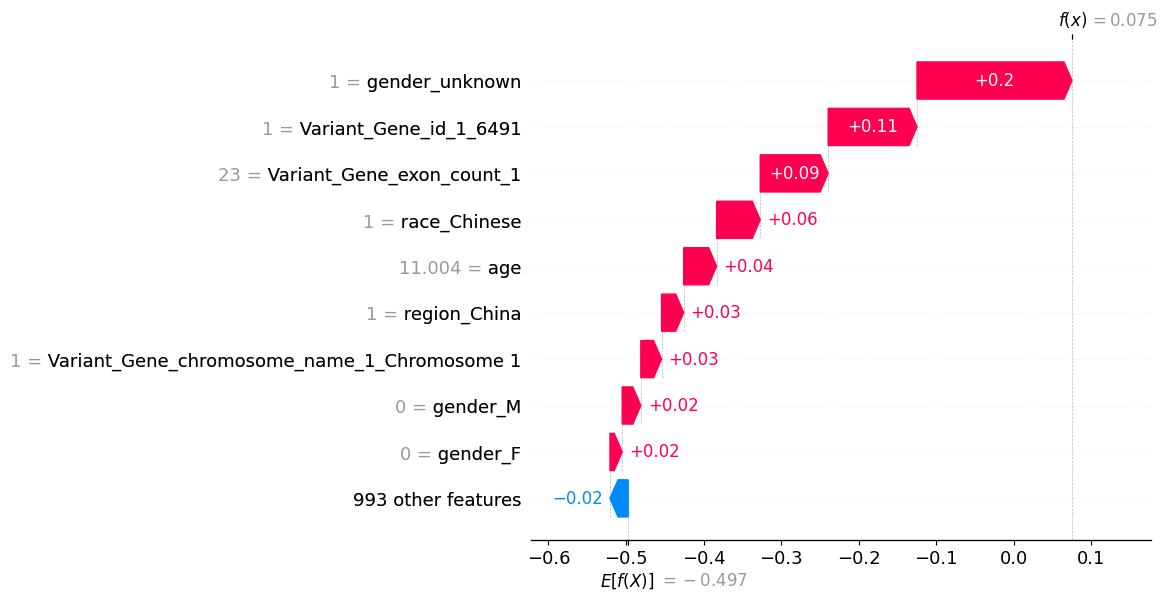

In [11]:
# For patient x, why predict the disease y
shap.plots.waterfall(shap_values[patient_number][..., disease_number])

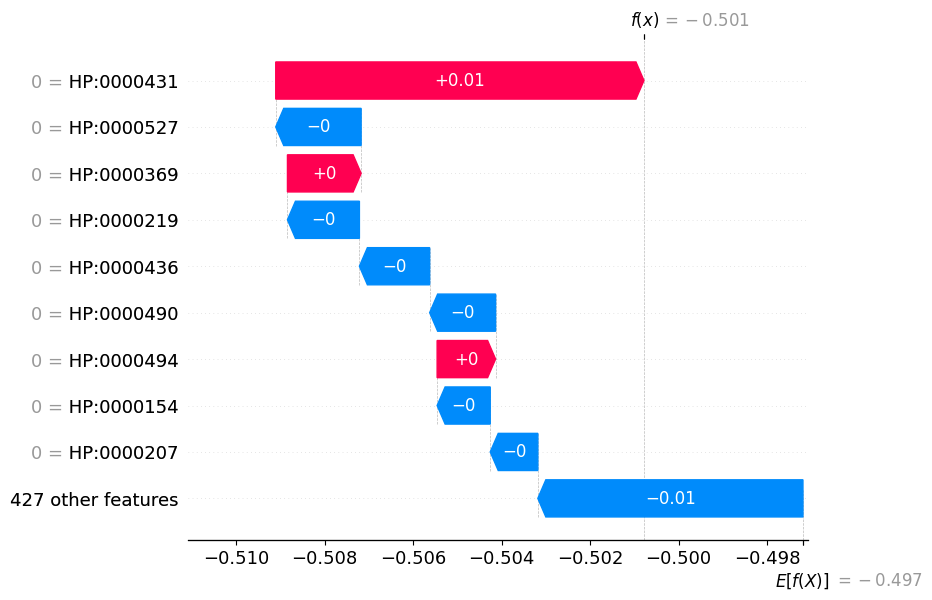

In [12]:
# phenotypes
shap.plots.waterfall(shap_values[patient_number][3:439, disease_number])

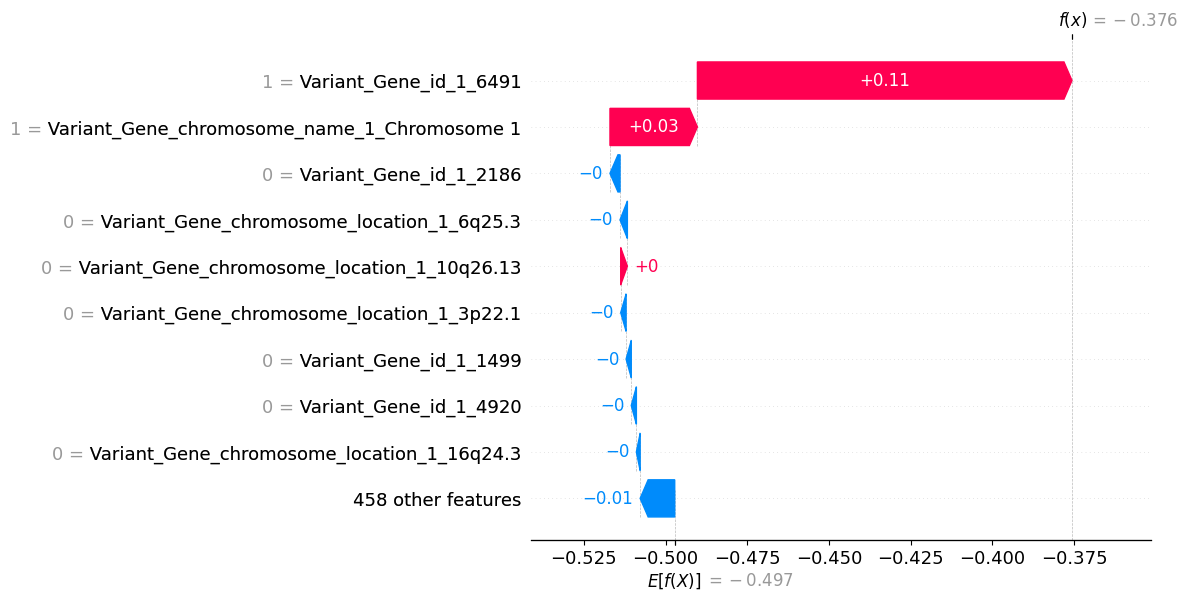

In [13]:
# genes
shap.plots.waterfall(shap_values[patient_number][534:1001, disease_number])

101200


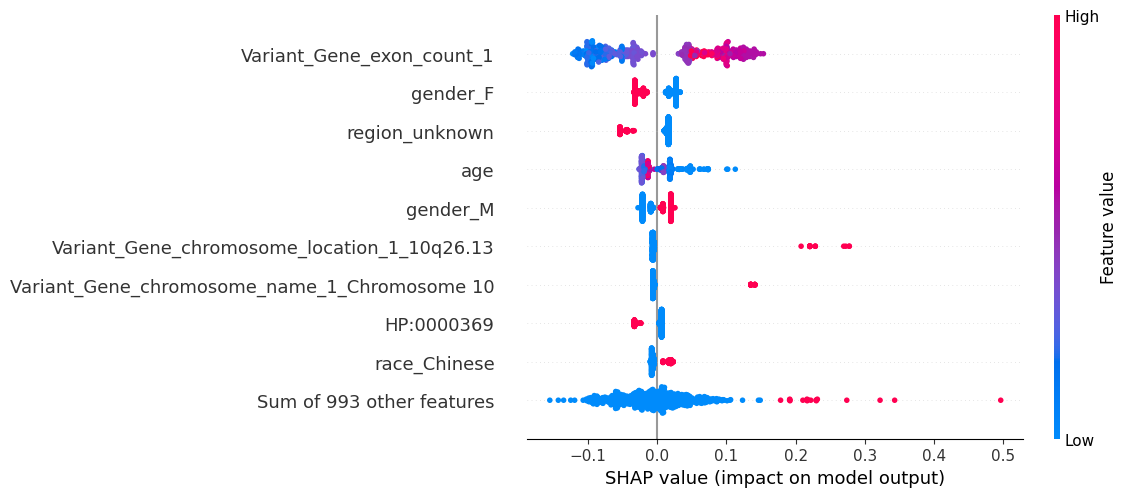

In [14]:
# beeswarm 
# APERT SYNDROME
print(label_mappings[0])
shap.plots.beeswarm(shap_values[..., 0])

101600


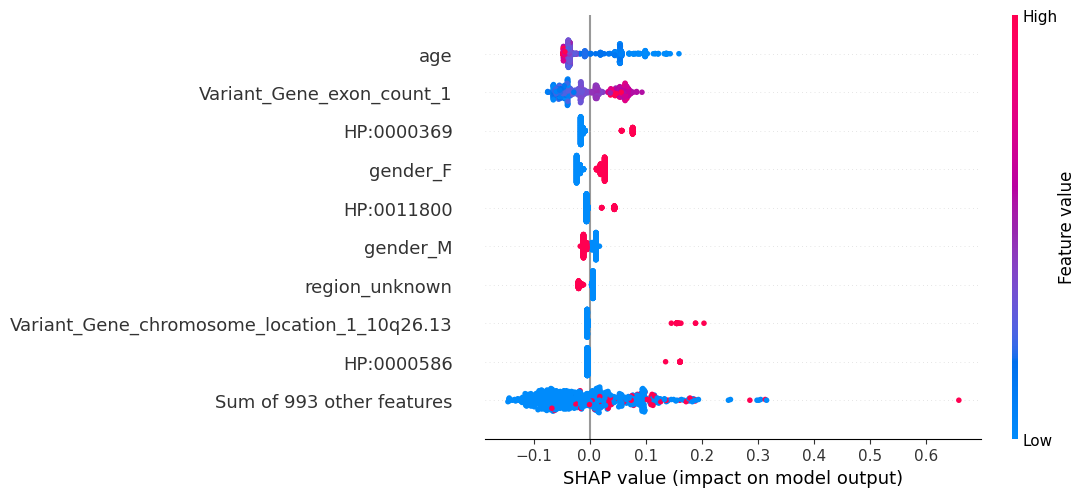

In [15]:
# PFEIFFER SYNDROME
print(label_mappings[1])
shap.plots.beeswarm(shap_values[..., 1])